# Projet

In [1]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

import glob
import torch 
import librosa
from os import listdir
import re
import audioread


In [2]:
import glob
import re
import librosa
import numpy as np

# Initialisation des listes et des variables
data = []  # Contiendra les données audio
labels = []  # Contiendra les labels des langues
genres = []  # Contiendra les genres (M/F)
languages = ['portuguese', 'china', 'french', 'quebec', 'maroc', 'japon', 'american', 'english', 'korean', 'spain', 'italy', 'tunis']
list_genres = ['M', 'F']
min_duration = None  # Durée minimale en échantillons

# Parcourir tous les fichiers MP3 dans le dossier 'clips'
for file_name in glob.glob('clips/*.mp3'):
    try:
        
        # Chargement de l'audio avec librosa
        audio, sr = librosa.load(file_name, sr=None)  # sr=None pour conserver la fréquence d'échantillonnage d'origine
        
        # Ajout des données audio
        data.append(audio)
        
        # Calcul de la durée minimale
        if min_duration is None or len(audio) < min_duration:
            print(file_name)
            min_duration = len(audio)
        
        # Création du vecteur des labels des langues
        for i, word in enumerate(languages):
            if re.search(word, file_name, re.IGNORECASE):  # Recherche insensible à la casse
                labels.append(i)
                break  # Une seule correspondance par fichier
        
        # Création du vecteur des genres
        for genre in list_genres:
            if re.search(genre, file_name, re.IGNORECASE):  # Recherche insensible à la casse
                genres.append(genre)
                break  # Une seule correspondance par fichier
        
    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file_name}: {e}")

# Conversion en tableaux NumPy pour une manipulation plus facile
data = np.array(data, dtype=object)  # Utiliser dtype=object pour des séquences audio de différentes longueurs
labels = np.array(labels)
genres = np.array(genres)

# Affichage des informations finales
print(f"La plus petite durée d'enregistrement est {min_duration} échantillons.")
print(f"la fréquence d'échantillonnage est {sr} Hz.")
print(f"Le nombre de fichiers traités est {len(data)}.")


clips/quebec_H_27.mp3
clips/tunis_H_17.mp3
La plus petite durée d'enregistrement est 176400 échantillons.
la fréquence d'échantillonnage est 48000 Hz.
Le nombre de fichiers traités est 1116.


In [3]:
def trim(record, min_duration):
    half_duration = min_duration//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [4]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i], min_duration)

y = np.array(labels)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(1116, 176400) and size of targets class is (1116,)


### Réduction de dimention

#### STFT

In [5]:
from sklearn.preprocessing import StandardScaler

X_scale = StandardScaler().fit_transform(X)

Shape of the spectrogram is (1025, 345)


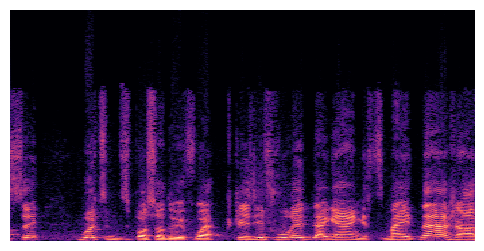

In [18]:
# Calculer le spectrogramme
stft_result = librosa.stft(X_scale[0], n_fft=2048, hop_length=512)
spectrogram = np.abs(stft_result)
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

# Créer le graphique du spectrogramme (sans axes ni titre)
plt.figure(figsize=(6, 3))
plt.axis('off')  # Désactiver les axes
librosa.display.specshow(spectrogram_db, sr=None, hop_length=512,
                            x_axis=None, y_axis=None, cmap="magma")

print(f"Shape of the spectrogram is {spectrogram_db.shape}")

In [7]:
# obtenir X_stft
X_stft = np.empty((X_scale.shape[0], spectrogram_db.shape[0], spectrogram_db.shape[1]))
for i in range(X_scale.shape[0]):
    stft_result = librosa.stft(X_scale[i], n_fft=2048, hop_length=512)
    spectrogram = np.abs(stft_result)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    X_stft[i] = spectrogram_db

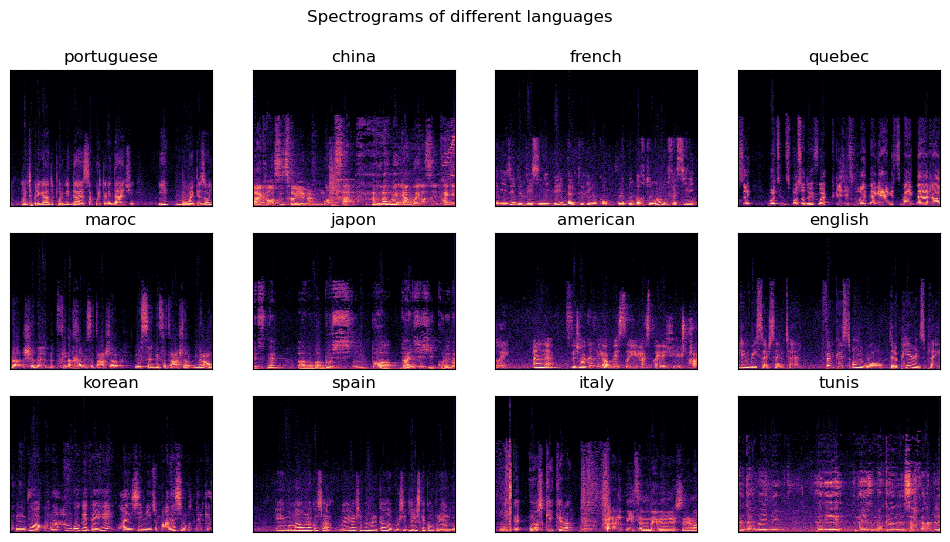

In [20]:
# afficher sur la même figure un spectrogramme pour chaque langue
plt.figure(figsize=(12, 6))
plt.axis('off')
for i in range(12):
    plt.subplot(3, 4, i+1)
    index = np.where(y == i)[0][0]
    plt.title(languages[i])
    librosa.display.specshow(X_stft[index], sr=None, hop_length=512,
                             x_axis=None, y_axis=None, cmap="magma")

plt.suptitle("Spectrograms of different languages")
plt.show()